In [40]:
import os

import tempfile
import time
import warnings

import cv2
import numpy as np
import tqdm
from matplotlib import pyplot as plt

import detectron2.data.transforms as T
from detectron2.data.detection_utils import read_image
from detectron2.utils.logger import setup_logger
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer

from mask2former import add_maskformer2_config
from mask2former.maskformer_sgmllm import MaskFormerForLLM

from detectron2.data.datasets.builtin_meta import COCO_CATEGORIES
from detectron2.data.datasets.lvis_v1_categories import LVIS_CATEGORIES

model_folder="runs/swinl-all_data-q200+50+50-res640-10k+40k-bs16-polylr"
cfg = MaskFormerForLLM.get_cfg(model_folder, ckpt_name="model_0034999.pth")
aug = T.ResizeShortestEdge(
    [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
)
model = build_model(cfg)
checkpointer = DetectionCheckpointer(model)
checkpointer.load(cfg.MODEL.WEIGHTS)
model = model.cuda().eval()

coco_classes = [c["name"].split("-")[0] for c in COCO_CATEGORIES]
lvis_classes = [c["name"].replace("_", " ") for c in LVIS_CATEGORIES]
classes = list(set(coco_classes).union(set(lvis_classes))) + ["text", "leg", "arm", "head"]
model.encode_labels(classes)

  criterion.empty_weight


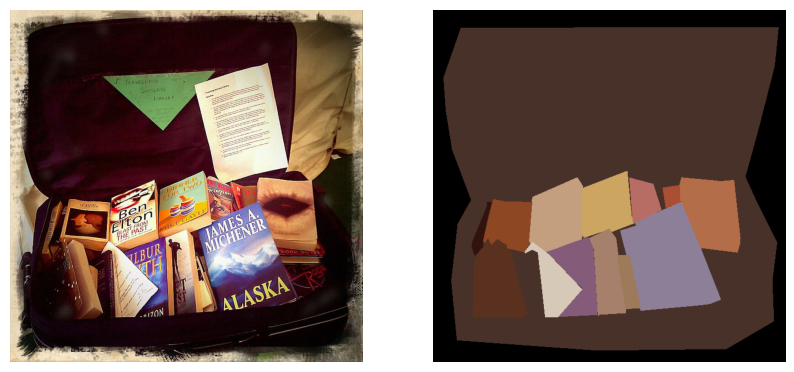

In [45]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from detectron2.data.detection_utils import read_image
# img_fn = "/home/ec2-user/project/SG-MLLM/notebooks/sample/sample3.jpg"
# img = Image.open(img_fn)
img_dir = "/data/coco/images/val2017/"
img_fn = os.path.join(img_dir, np.random.choice(os.listdir(img_dir)))
# img_fn = "/data/coco/images/val2017/000000173033.jpg"
# print(img_fn)
img_id = int(img_fn.split("/")[-1].split(".")[0].split("_")[-1])
ann_fn = os.path.join(f"/data/coco/annotations/panoptic_val2017/{img_id:012d}.png")
img = read_image(img_fn, format="RGB")


# img_w, img_h = img.shape[:2]
# img_padded = np.zeros((max(img_w, img_h), max(img_w, img_h), 3), dtype=np.uint8)
# img_padded[:img_w, :img_h, :] = img
# img = img_padded

image = aug.get_transform(img).apply_image(img)
ann = read_image(ann_fn, format="RGB")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[0].axis('off')
ax[1].imshow(ann)
ax[1].axis('off')
plt.show()

pixel_mean = torch.Tensor(model.pixel_mean).view(-1, 1, 1).cpu()
pixel_std = torch.Tensor(model.pixel_std).view(-1, 1, 1).cpu()
# pixel_mean = model.pixel_mean
# pixel_std = model.pixel_std

image_pt = torch.as_tensor(img.astype("float32").transpose(2, 0, 1))
image_pt = (image_pt - pixel_mean) / pixel_std
image_pt = image_pt.cuda()

with torch.no_grad():
    scores, pred = model(image_pt.unsqueeze(0))
    pred = pred[0]
    scores = scores[0]


tensor([85, 82, 80, 79, 78, 78, 77, 77, 76, 76, 76, 75, 74, 73, 72, 71, 70, 70,
        67, 64, 62, 60, 60, 60, 59, 57, 56, 55, 55, 54, 54, 53, 52, 50, 49, 44,
        43, 41, 40, 39, 38, 38, 38, 37, 37, 37, 35, 35, 34, 33, 32, 31, 31, 29,
        29, 26, 22, 18, 13, 12,  9,  8,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0])


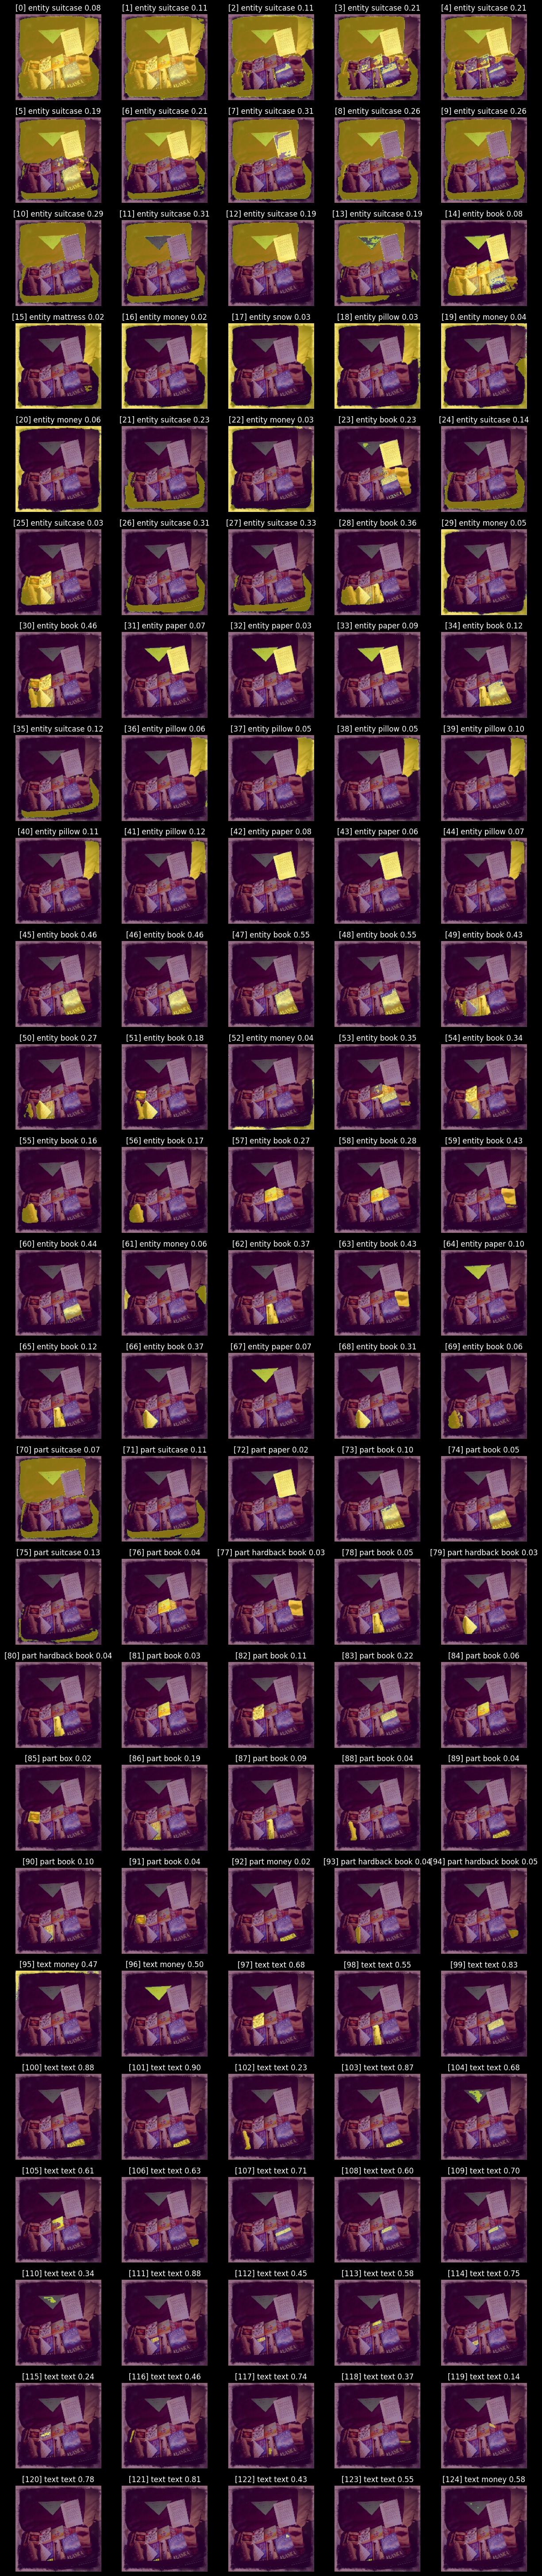

In [46]:

masks = pred.cpu() > 0
areas = masks.sum(dim=(1, 2))
mask_shape = masks.shape[-2:]
h, w = mask_shape

fig, axes = plt.subplots(25, 5, figsize=(15, 75*h/w), facecolor = 'black')
axes = axes.flatten()

img_resized = cv2.resize(img, mask_shape[::-1])

entity_masks = masks[:200]
entity_areas = areas[:200]
entity_sorted_index = torch.argsort(entity_areas, descending=True)

part_masks = masks[200:250]
part_areas = areas[200:250]
part_sorted_index = torch.argsort(part_areas, descending=True)

text_masks = masks[250:]
text_areas = areas[250:]
text_sorted_index = torch.argsort(text_areas, descending=True)

num_entity = 70
num_part = 25
num_text = 25

all_area_sorted = torch.sort(areas, descending=True)
print(all_area_sorted[0][-100:])

for i, ax in enumerate(axes):
    if i < num_entity:
        sidx = entity_sorted_index[i]
        axes[i].axis("off")
        axes[i].imshow(img_resized)
        axes[i].imshow(entity_masks[sidx].numpy(), alpha=0.5)
        # axes[i].set_title(f"[{i}] entity {entity_areas[sidx].item()}",color='white')
        cls_scores = scores[sidx]
        cls_score, cls_idx = torch.max(cls_scores, dim=0)
        cls_name = model.classes[cls_idx]
        axes[i].set_title(f"[{i}] entity {cls_name} {cls_score:.2f}",color='white')

    elif i < (num_entity + num_part):
        sidx = part_sorted_index[i - num_entity]
        axes[i].axis("off")
        axes[i].imshow(img_resized)
        axes[i].imshow(part_masks[sidx].numpy(), alpha=0.5)
        # axes[i].set_title(f"[{i}] part {part_areas[sidx].item()}",color='white')
        cls_scores = scores[200+sidx]
        cls_score, cls_idx = torch.max(cls_scores, dim=0)
        cls_name = model.classes[cls_idx]
        axes[i].set_title(f"[{i}] part {cls_name} {cls_score:.2f}",color='white')
    
    else:
        sidx = text_sorted_index[i - num_entity - num_part]
        axes[i].axis("off")
        axes[i].imshow(img_resized)
        axes[i].imshow(text_masks[sidx].numpy(), alpha=0.5)
        # axes[i].set_title(f"[{i}] text {text_areas[sidx].item()}",color='white')
        cls_scores = scores[250+sidx]
        cls_score, cls_idx = torch.max(cls_scores, dim=0)
        cls_name = model.classes[cls_idx]
        axes[i].set_title(f"[{i}] text {cls_name} {cls_score:.2f}",color='white')